In [1]:
# Basic Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

In [2]:
# Complicated Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm.notebook as tqdm

import random
import time

#from google.colab import drive
from pathlib import Path
import os

from functools import *
import pandas as pd
import gc

import itertools

import matplotlib.pyplot as plt
%matplotlib inline


from torch.utils.data import DataLoader

from collections import defaultdict

In [3]:
p = 113
def label_fn(x, y):
    z = 0
    if x ** 2 < np.sqrt(y) * 200:
        z += 3
    if y ** 2 < np.sqrt(x) * 600:
        z -= 2
    z += int(x ** 1.5) % 8 - 5
    if y < (p - x + 20) and z < -3:
        z += 5.5
    if z < 0:
        return 0
    else:
        return 1

labels = np.zeros((p, p))
for x in range(p):
    for y in range(p):
        labels[x][y] = label_fn(x, y)


# Shared functions

In [4]:
import copy

class allVOMs:
    def __init__(self, sample_left, sample_right = None):
        # Left (L) vs Right (R)
        # True (T) vs False (F)
        # Center (C) vs Wall (W)
        self.ltc = copy.deepcopy(sample_left)
        self.ltw = copy.deepcopy(sample_left)
        self.lfc = copy.deepcopy(sample_left)
        self.lfw = copy.deepcopy(sample_left)
        if sample_right is None:
            sample_right = sample_left
        self.rtc = copy.deepcopy(sample_right)
        self.rtw = copy.deepcopy(sample_right)
        self.rfc = copy.deepcopy(sample_right)
        self.rfw = copy.deepcopy(sample_right)

class allMLPs:
    def __init__(self):
        self.ltc = np.zeros((p,p))
        self.ltw = np.zeros((p,p))
        self.lfc = np.zeros((p,p))
        self.lfw = np.zeros((p,p))
        self.rtc = np.zeros((p,p))
        self.rtw = np.zeros((p,p))
        self.rfc = np.zeros((p,p))
        self.rfw = np.zeros((p,p))
        
    def setMLPs(self,VOMs,VOMy,i,j):
        self.ltc[i][j] = np.max([VOMs.ltc[i] - VOMy[j],0])
        self.ltw[i][j] = np.max([VOMs.ltw[i] - VOMy[j],0])
        self.lfc[i][j] = np.max([VOMs.lfc[i] - VOMy[j],0])
        self.lfw[i][j] = np.max([VOMs.lfw[i] - VOMy[j],0])
        
        self.rtc[i][j] = np.max([VOMy[j] - VOMs.rtc[i],0])
        self.rtw[i][j] = np.max([VOMy[j] - VOMs.rtw[i],0])
        self.rfc[i][j] = np.max([VOMy[j] - VOMs.rfc[i],0])
        self.rfw[i][j] = np.max([VOMy[j] - VOMs.rfw[i],0])

In [5]:
def set_VOMs(x_f,y_f, VOMS, walls_to_left, skip_zero = False):
    for x,y in zip(x_f,y_f):
        if skip_zero and y == 0:            
            VOMS.rtc[x] = 200.
            VOMS.ltc[x] = 0.
            VOMS.lfc[x] = 0.
            VOMS.rfc[x] = 200.
            VOMS.rtw[x] = 200.
            VOMS.ltw[x] = 0.
            VOMS.lfw[x] = 0.
            VOMS.rfw[x] = 200.
        elif x >= 0 and x <= 112 and y >= 0 and y <= 112:
            if labels[x][int(y)-1]!=labels[x][int(y)]:
                if labels[x][int(y)-1] == 1:
                    # print(x)
                    VOMS.lfc[x] = 0.
                    VOMS.rtc[x] = 200.
                    VOMS.lfw[x] = 0.
                    VOMS.rtw[x] = 200.
                    if x in walls_to_left:
                        VOMS.ltc[x] = 0.
                        VOMS.rfw[x] = 200.
                    else:
                        VOMS.rfc[x] = 200.
                        VOMS.ltw[x] = 0.
                else:
                    VOMS.ltc[x] = 0.
                    VOMS.rfc[x] = 200.
                    VOMS.ltw[x] = 0.
                    VOMS.rfw[x] = 200.
                    if x in walls_to_left:
                        VOMS.lfc[x] = 0.
                        VOMS.rtw[x] = 200.
                    else:
                        VOMS.rtc[x] = 200.
                        VOMS.lfw[x] = 0.
            else:
                VOMS.rtc[x] = 200.
                VOMS.ltc[x] = 0.
                VOMS.lfc[x] = 0.
                VOMS.rfc[x] = 200.
                VOMS.rtw[x] = 200.
                VOMS.ltw[x] = 0.
                VOMS.lfw[x] = 0.
                VOMS.rfw[x] = 200.
        else:
            VOMS.rtc[x] = 200.
            VOMS.ltc[x] = 0.
            VOMS.lfc[x] = 0.
            VOMS.rfc[x] = 200.
            VOMS.rtw[x] = 200.
            VOMS.ltw[x] = 0.
            VOMS.lfw[x] = 0.
            VOMS.rfw[x] = 200.
    return VOMS

def get_MLP_activations(VOMs,VOMy):
    MLPs = allMLPs()

    for i in range(p):
        for j in range(p):
            MLPs.setMLPs(VOMs,VOMy,i,j)
    return MLPs

def plotter(to_plot, title = None):
    fig, ax = plt.subplots(figsize=(8,8))

    cax = ax.imshow(to_plot, aspect='auto',cmap='coolwarm', vmin=-.1, vmax=.1)

    labels2 = list(range(0, 114,10))
    ax.set_yticks(labels2)
    ax.set_yticklabels(labels2[::1])

    plt.xlabel('Y')
    plt.ylabel('X')
    if title != None:
        plt.title(title)

    # Show the x axis at the top
    plt.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)

    plt.show()

# Y Embedding - just one and it's linear

In [6]:
VOMy = np.linspace(0, 113, 114)

# Function 2 (y = (p - x + 20)) Embedding

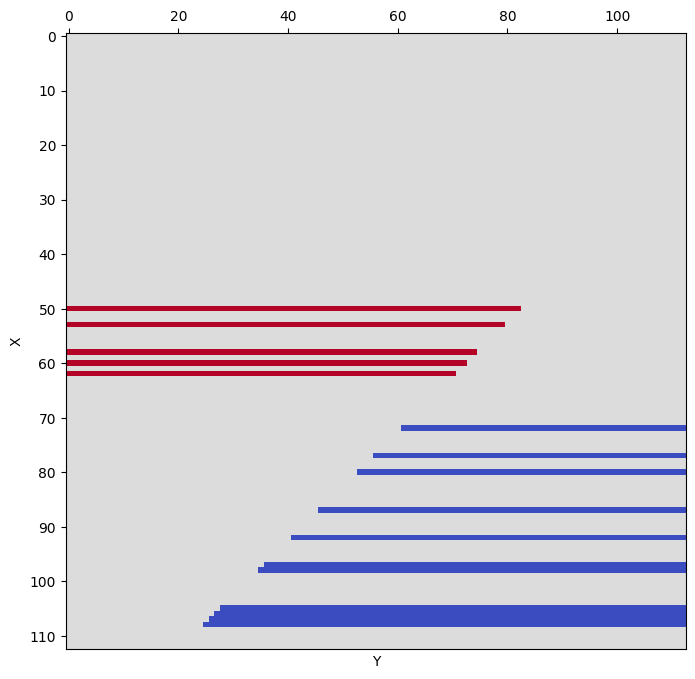

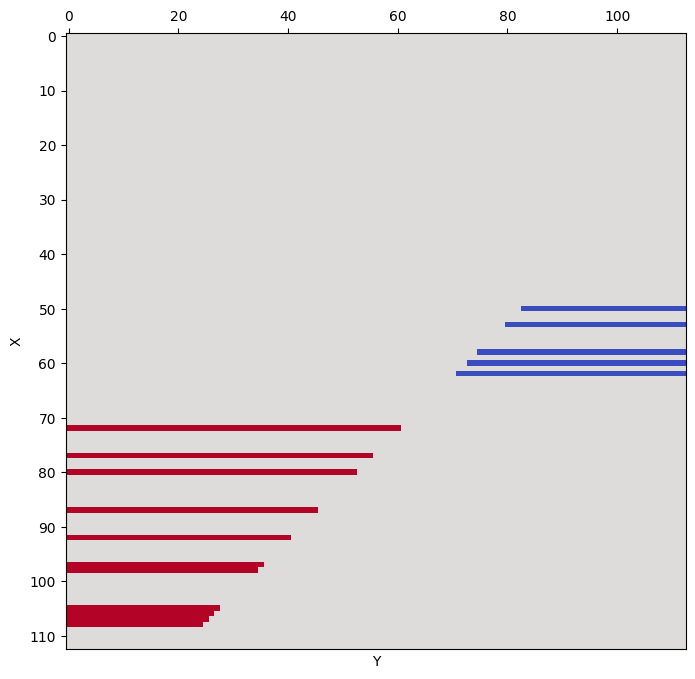

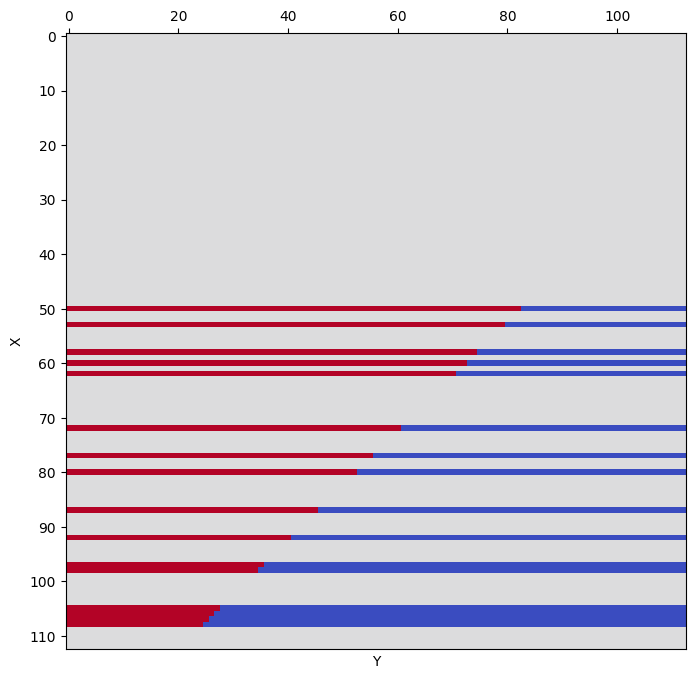

In [7]:
# 1) Define function and important values:
x_f2 = np.arange(0,114)
y_f2 = np.ceil(133-x_f2)

walls_to_left = range(68,113)

sample_VOM_x2 = y_f2 - .5

x2VOMS = allVOMs(sample_VOM_x2)
x2VOMS = set_VOMs(x_f2,y_f2, x2VOMS, walls_to_left)

# # 5) Calc MLP
MLPs2 = get_MLP_activations(x2VOMS,VOMy)

# 6) Plot.
plotter(MLPs2.ltc-MLPs2.lfc-MLPs2.rfc+MLPs2.rtc)
plotter(MLPs2.ltw-MLPs2.lfw-MLPs2.rfw+MLPs2.rtw)
plotter(MLPs2.ltc-MLPs2.lfc-MLPs2.rfc+MLPs2.rtc+MLPs2.ltw-MLPs2.lfw-MLPs2.rfw+MLPs2.rtw)

# Function 0 (x ** 2 < np.sqrt(y) * 200) Embedding

In [8]:
# 1) Define function and important values:
x_f0 = np.arange(48)
# row 0 was giving me some issues, the + .0000001 fixes these issues.
# (I think I wasn't handling some boundary condition correctly).
y_f0 = np.ceil(x_f0**4 / 200**2 + .0000001).astype(int)

sample_VOM_x0 = np.zeros((114))
sample_VOM_x0[:48] = y_f0 - .5
sample_VOM_x0[48:114] = 0.

sample_VOM_x0b = np.zeros((114))
sample_VOM_x0b[:48] = y_f0 - .5
sample_VOM_x0b[48:114] = 200.

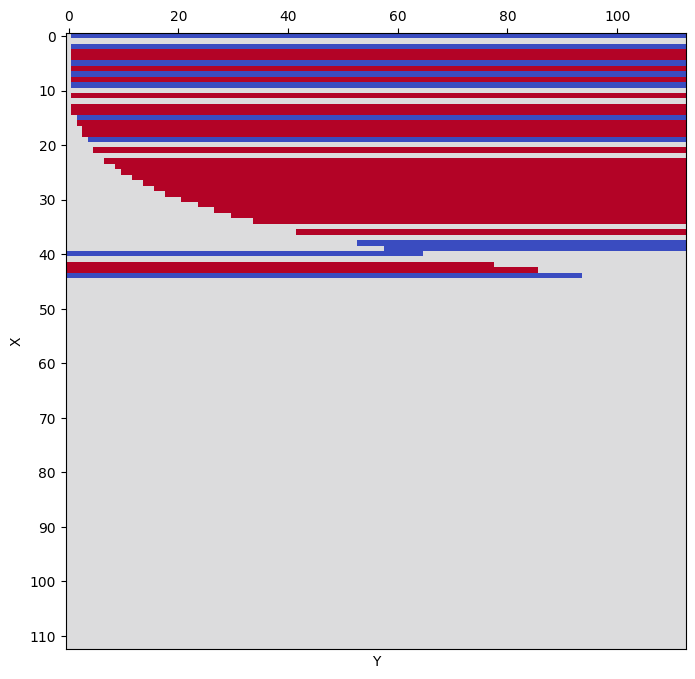

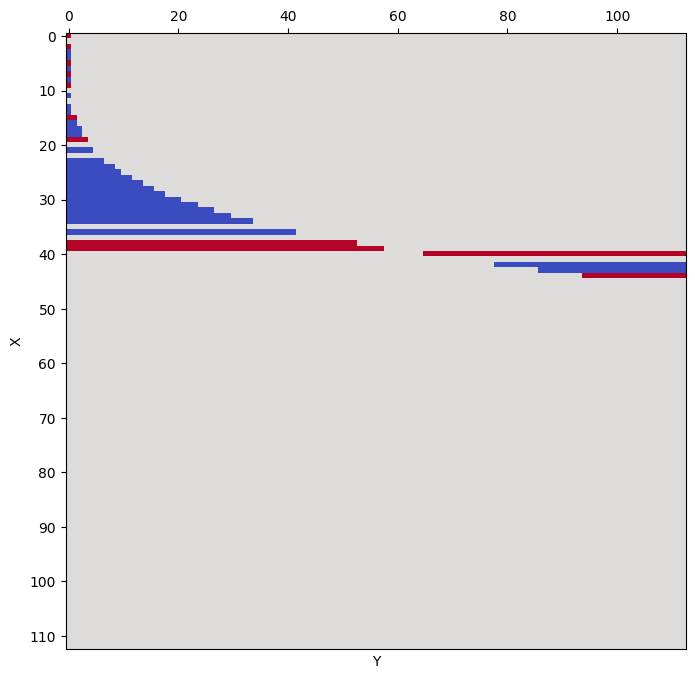

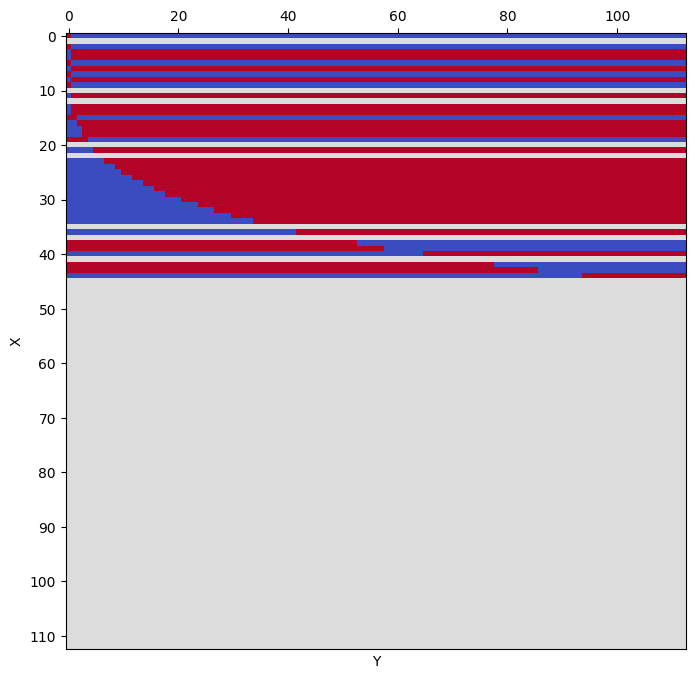

In [9]:
walls_to_left = range(40)

x0VOMS = allVOMs(sample_VOM_x0,sample_VOM_x0b)
x0VOMS = set_VOMs(x_f0,y_f0, x0VOMS, walls_to_left)

# # 5) Calc MLP
MLPs0 = get_MLP_activations(x0VOMS,VOMy)

# 6) Plot.
plotter(MLPs0.ltc-MLPs0.lfc-MLPs0.rfc+MLPs0.rtc)
plotter(MLPs0.ltw-MLPs0.lfw-MLPs0.rfw+MLPs0.rtw)
plotter(MLPs0.ltw-MLPs0.lfw-MLPs0.rfw+MLPs0.rtw+MLPs0.ltc-MLPs0.lfc-MLPs0.rfc+MLPs0.rtc)

# Function 1 (y ** 2 < np.sqrt(x) * 600) Embedding

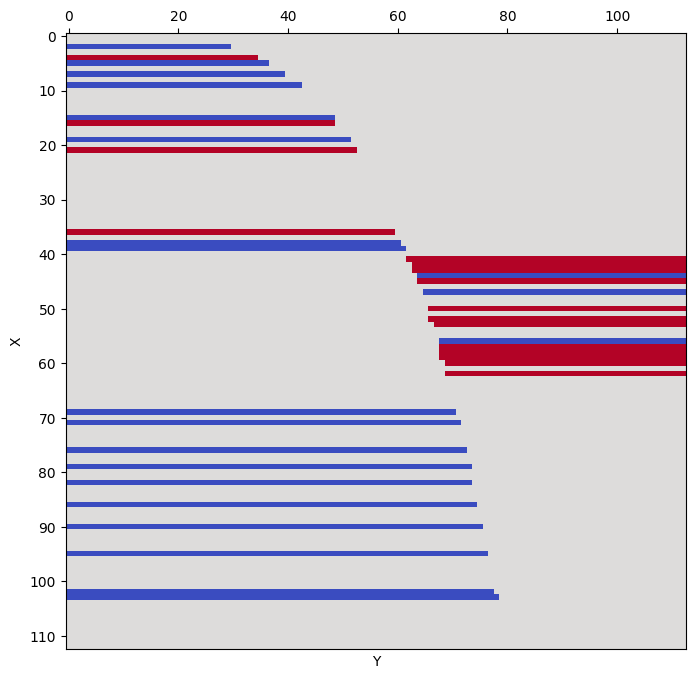

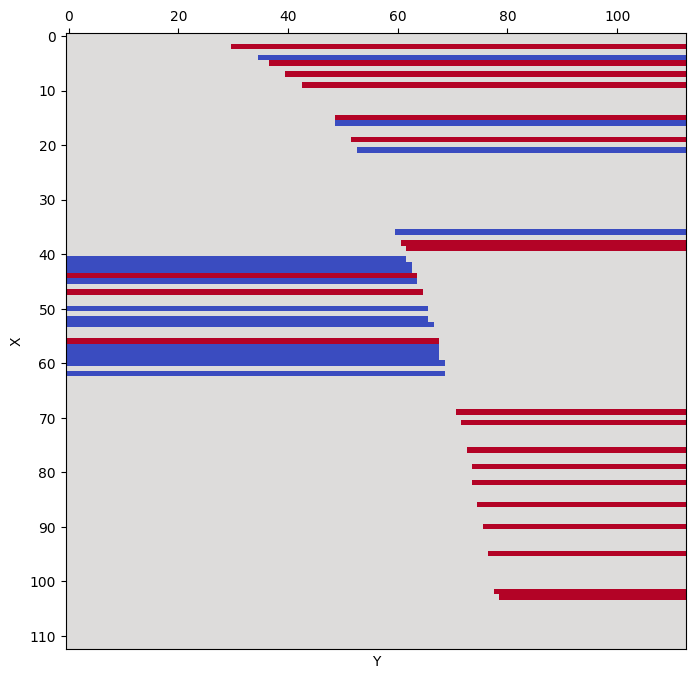

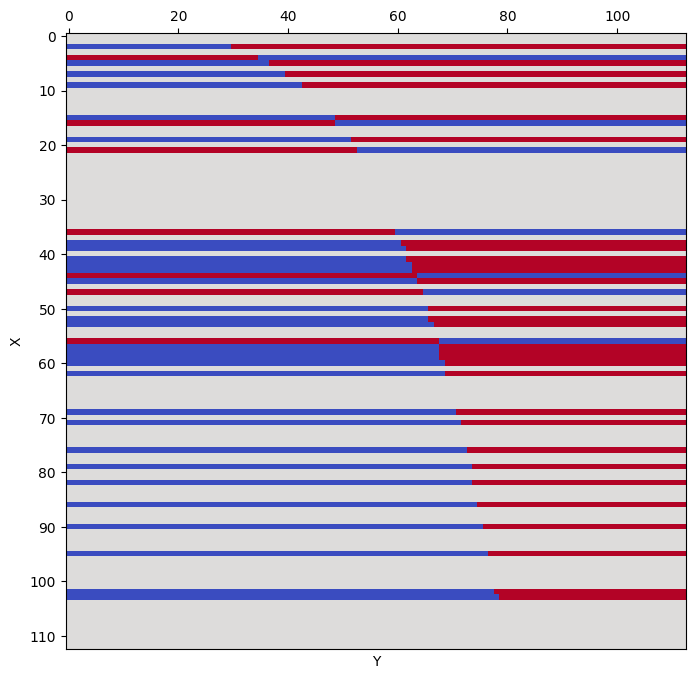

In [10]:
# 1) Define function and important values:
x_f1 = np.arange(114)
y_f1 = np.ceil(x_f1**.25 * 600**.5).astype(int)

walls_to_left = range(40,68)


sample_VOM_x1 = y_f1 - .5
x1VOMS = allVOMs(sample_VOM_x1)
x1VOMS = set_VOMs(x_f1,y_f1, x1VOMS, walls_to_left, True)

# # 5) Calc MLP
MLPs1 = get_MLP_activations(x1VOMS,VOMy)

# 6) Plot.
plotter(MLPs1.ltc-MLPs1.lfc-MLPs1.rfc+MLPs1.rtc)
plotter(MLPs1.ltw-MLPs1.lfw-MLPs1.rfw+MLPs1.rtw)
plotter(MLPs1.ltw-MLPs1.lfw-MLPs1.rfw+MLPs1.rtw+MLPs1.ltc-MLPs1.lfc-MLPs1.rfc+MLPs1.rtc)

# Function 3 (X's that don't depend on Y) Embedding

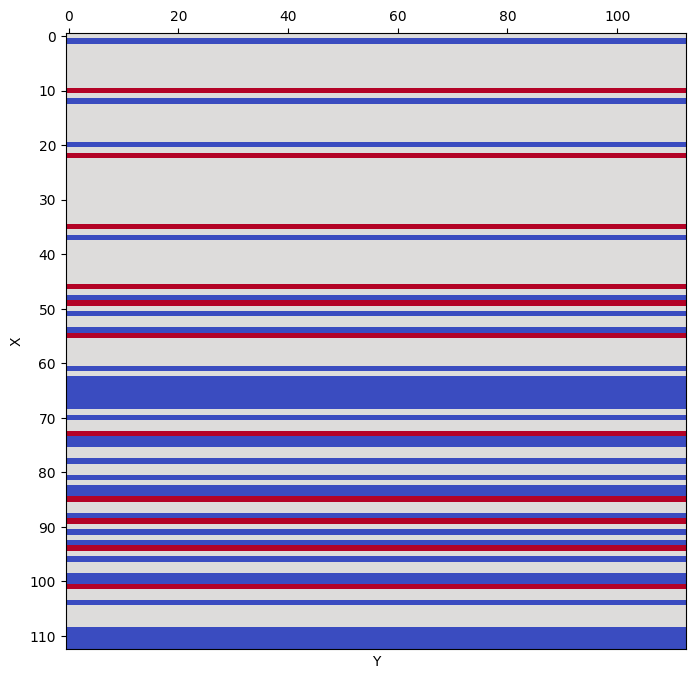

In [11]:
# 2) Define VOMs
VOMx3t = np.zeros((114))
VOMx3f = np.zeros((114))

# 3) Set VOMs based on function
for x in range(113):
    if np.sum(labels[int(x)])==113:
            VOMx3t[int(x)] = 1.0
    elif np.sum(labels[int(x)])==0:
            VOMx3f[int(x)] = 1.0   

# 5) Calc MLP

MLPx3_t = np.zeros((p,p))
MLPx3_f = np.zeros((p,p))

for i in range(p):
    for j in range(p):
        MLPx3_t[i][j] = VOMx3t[i]
        MLPx3_f[i][j] = VOMx3f[i]
        
# 6) Plot
plotter(MLPx3_t-MLPx3_f)

# Combine into proposed solution

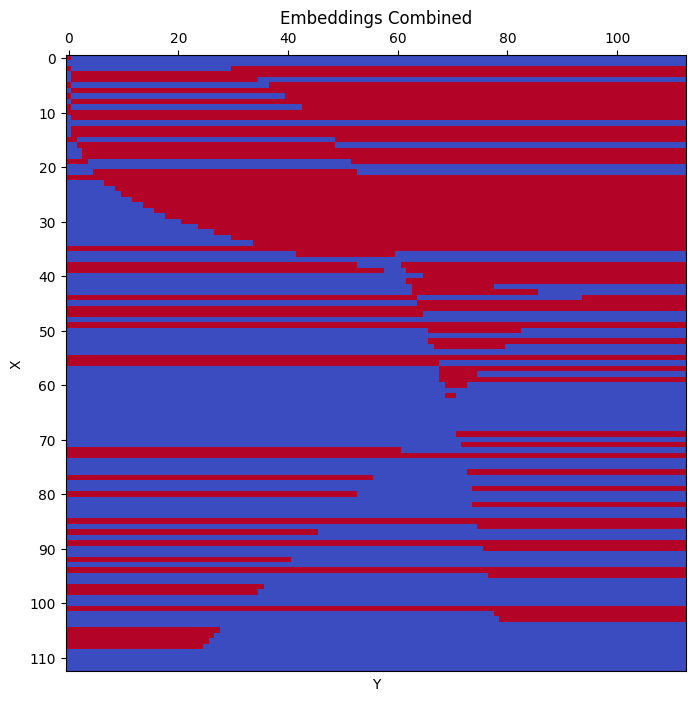

1.0


In [12]:
proposed_solution =\
    1*(MLPs0.ltc-MLPs0.lfc-MLPs0.rfc+MLPs0.rtc+\
          MLPs2.ltc-MLPs2.lfc-MLPs2.rfc+MLPs2.rtc+\
          MLPs1.ltc-MLPs1.lfc-MLPs1.rfc+MLPs1.rtc)+\
    100*(MLPs2.ltw-MLPs2.lfw-MLPs2.rfw+MLPs2.rtw+\
            MLPs0.ltw-MLPs0.lfw-MLPs0.rfw+MLPs0.rtw+\
            MLPs1.ltw-MLPs1.lfw-MLPs1.rfw+MLPs1.rtw)+\
    (MLPx3_t-MLPx3_f)

plotter(proposed_solution, "Embeddings Combined")
print(sum(sum((proposed_solution>0) == labels))/113.0/113.0)
assert(sum(sum((proposed_solution>0) == labels))/113.0/113.0 == 1.0)

## transformer

In [13]:
num_layers = 1
batch_style = 'full'
d_vocab = p + 1
n_ctx = 3

d_model = 128
d_mlp = 8
num_heads = 8
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' # ['ReLU', 'GeLU']
use_ln = False
fn = label_fn

In [14]:
# A helper class to get access to intermediate activations (inspired by Garcon)
# It's a dummy module that is the identity function by default
# I can wrap any intermediate activation in a HookPoint and get a convenient 
# way to add PyTorch hooks
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []
    
    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name
    
    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output, 
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")
    
    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")
    
    def forward(self, x):
        return x
    
# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        # self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))
        self.W_U = nn.Parameter(torch.randn(d_model, 2)/np.sqrt(2))
    
    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))
    
    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]
         

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon
    
    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']
        
    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        # Set to False for experiment #2 qqq
        if True:
            if self.act_type=='ReLU':
                x = F.relu(x)
            elif self.act_type=='GeLU':
                x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()
    
    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)
    
    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache
    
    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')
    
    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

In [15]:
artificial_model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln)
artificial_model = artificial_model.to('cuda')

In [16]:
print(artificial_model)

Transformer(
  (embed): Embed()
  (pos_embed): PosEmbed()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn): HookPoint()
        (hook_attn_pre): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mid): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)


In [17]:
def print_parameter_sizes(model):
    for name, param in artificial_model.named_parameters():
        print(f'Parameter: {name}, Size: {param.size()}')

# Assuming 'transformer' is your model
print_parameter_sizes(artificial_model)

Parameter: embed.W_E, Size: torch.Size([128, 114])
Parameter: pos_embed.W_pos, Size: torch.Size([3, 128])
Parameter: blocks.0.attn.W_K, Size: torch.Size([8, 16, 128])
Parameter: blocks.0.attn.W_Q, Size: torch.Size([8, 16, 128])
Parameter: blocks.0.attn.W_V, Size: torch.Size([8, 16, 128])
Parameter: blocks.0.attn.W_O, Size: torch.Size([128, 128])
Parameter: blocks.0.mlp.W_in, Size: torch.Size([8, 128])
Parameter: blocks.0.mlp.b_in, Size: torch.Size([8])
Parameter: blocks.0.mlp.W_out, Size: torch.Size([128, 8])
Parameter: blocks.0.mlp.b_out, Size: torch.Size([128])
Parameter: unembed.W_U, Size: torch.Size([128, 2])


In [18]:
# This is in a function b/c I manipulate it later and want to easily undo the manipulation.
def set_W_E(artificial_model):
    with torch.no_grad():
        artificial_model.embed.W_E = torch.nn.Parameter(torch.zeros(30,114))

        artificial_model.embed.W_E[0] = torch.from_numpy(VOMy).to('cuda')
        next_loc = 1

        for VOM in [x0VOMS,x1VOMS,x2VOMS]:
            artificial_model.embed.W_E[next_loc+0] = torch.from_numpy(VOM.ltc).to('cuda')
            artificial_model.embed.W_E[next_loc+1] = torch.from_numpy(VOM.ltw).to('cuda')
            artificial_model.embed.W_E[next_loc+2] = torch.from_numpy(VOM.lfc).to('cuda')
            artificial_model.embed.W_E[next_loc+3] = torch.from_numpy(VOM.lfw).to('cuda')
            artificial_model.embed.W_E[next_loc+4] = torch.from_numpy(VOM.rtc).to('cuda')
            artificial_model.embed.W_E[next_loc+5] = torch.from_numpy(VOM.rtw).to('cuda')
            artificial_model.embed.W_E[next_loc+6] = torch.from_numpy(VOM.rfc).to('cuda')
            artificial_model.embed.W_E[next_loc+7] = torch.from_numpy(VOM.rfw).to('cuda')
            next_loc+=8
        artificial_model.embed.W_E[next_loc] =  torch.from_numpy(VOMx3t).to('cuda')
        artificial_model.embed.W_E[next_loc+1] =  torch.from_numpy(VOMx3f).to('cuda')

        # override earlier mistake:
        artificial_model.embed.W_E[:,113] = 0.0

        # For pos embedding
        artificial_model.embed.W_E[next_loc+2] =  nn.Parameter(torch.zeros(114)).to('cuda')
        artificial_model.embed.W_E[next_loc+3] =  nn.Parameter(torch.zeros(114)).to('cuda')
        artificial_model.embed.W_E[next_loc+4] =  nn.Parameter(torch.zeros(114)).to('cuda')

    print(artificial_model.embed.W_E.shape)
    artificial_model = artificial_model.to('cuda')

set_W_E(artificial_model)

torch.Size([30, 114])


In [19]:
with torch.no_grad():
    artificial_model.pos_embed.W_pos = torch.nn.Parameter(torch.zeros(3,30))
    # could have used 10 * eye(3)
    artificial_model.pos_embed.W_pos[0,27] = 10.0
    artificial_model.pos_embed.W_pos[1,28] = 10.0
    artificial_model.pos_embed.W_pos[2,29] = 10.0

artificial_model = artificial_model.to('cuda')

print(artificial_model.pos_embed.W_pos.shape)


torch.Size([3, 30])


In [20]:
with torch.no_grad():
    artificial_model.blocks[0].attn.W_K = torch.nn.Parameter(torch.zeros(2,1,30))
    artificial_model.blocks[0].attn.W_K[0,0,27] = 1.0
    artificial_model.blocks[0].attn.W_K[1,0,28] = 1.0

    artificial_model.blocks[0].attn.W_Q = torch.nn.Parameter(torch.zeros(2,1,30))
    artificial_model.blocks[0].attn.W_Q[:,0,29] = 1.0

artificial_model = artificial_model.to('cuda')

print(artificial_model.blocks[0].attn.W_K.shape)


torch.Size([2, 1, 30])


In [21]:
artificial_model.blocks[0]

TransformerBlock(
  (attn): Attention(
    (hook_k): HookPoint()
    (hook_q): HookPoint()
    (hook_v): HookPoint()
    (hook_z): HookPoint()
    (hook_attn): HookPoint()
    (hook_attn_pre): HookPoint()
  )
  (mlp): MLP(
    (hook_pre): HookPoint()
    (hook_post): HookPoint()
  )
  (hook_attn_out): HookPoint()
  (hook_mlp_out): HookPoint()
  (hook_resid_pre): HookPoint()
  (hook_resid_mid): HookPoint()
  (hook_resid_post): HookPoint()
)

In [22]:
def set_W_V(artificial_model, use_v2 = False):
    with torch.no_grad():
        artificial_model.blocks[0].attn.W_V = torch.nn.Parameter(torch.zeros(2,30,30))
        artificial_model.blocks[0].attn.W_V[0,1:27,1:27] = nn.Parameter(torch.eye(26))
        artificial_model.blocks[0].attn.W_V[1,0,0] = nn.Parameter(torch.eye(1))

        if use_v2:
            artificial_model.blocks[0].attn.W_V[1,5:9,0] = -2*torch.nn.Parameter(torch.ones(4))
            artificial_model.blocks[0].attn.W_V[1,13:17,0] = -2*torch.nn.Parameter(torch.ones(4))
            artificial_model.blocks[0].attn.W_V[1,21:25,0] = -2*torch.nn.Parameter(torch.ones(4))

    artificial_model = artificial_model.to('cuda')

    print(artificial_model.blocks[0].attn.W_V.shape)
    
set_W_V(artificial_model)

torch.Size([2, 30, 30])


In [23]:
x = artificial_model.embed.forward(torch.tensor([[1,0,113]]))
# print(x)
x = artificial_model.pos_embed.forward(x)
# print(x)
x = x.to('cuda')

k = (torch.einsum('ihd,bpd->biph', artificial_model.blocks[0].attn.W_K, x))
q = (torch.einsum('ihd,bpd->biph', artificial_model.blocks[0].attn.W_Q, x))
attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - artificial_model.blocks[0].attn.mask[:x.shape[-2], :x.shape[-2]])
attn_matrix = F.softmax((attn_scores_masked/np.sqrt(artificial_model.blocks[0].attn.d_head)), dim=-1)

print(attn_matrix[0,:,2,:])
assert(np.isclose(attn_matrix[0,0,2,0].item(),1.0,.00001))
assert(np.isclose(attn_matrix[0,1,2,1].item(),1.0,.00001))

# W_O not set yet.
# v = (torch.einsum('ihd,bpd->biph', artificial_model.blocks[0].attn.W_V, x))
# z = (torch.einsum('biph,biqp->biqh', v, attn_matrix))
# z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')

# out = torch.einsum('df,bqf->bqd', artificial_model.blocks[0].attn.W_O, z_flat)

# print(x)
# print(out)

print(attn_matrix[0,:,:,:])

tensor([[1.0000e+00, 1.3888e-11, 1.3888e-11],
        [1.3888e-11, 1.0000e+00, 1.3888e-11]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[[1.0000e+00, 0.0000e+00, 0.0000e+00],
         [5.0000e-01, 5.0000e-01, 0.0000e+00],
         [1.0000e+00, 1.3888e-11, 1.3888e-11]],

        [[1.0000e+00, 0.0000e+00, 0.0000e+00],
         [5.0000e-01, 5.0000e-01, 0.0000e+00],
         [1.3888e-11, 1.0000e+00, 1.3888e-11]]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [24]:
with torch.no_grad():
    artificial_model.blocks[0].attn.W_O = torch.nn.Parameter(torch.zeros(30,60))
    artificial_model.blocks[0].attn.W_O[:,0:30] = nn.Parameter(torch.eye(30))
    artificial_model.blocks[0].attn.W_O[:,30:60] = nn.Parameter(torch.eye(30))

artificial_model = artificial_model.to('cuda')

print(artificial_model.blocks[0].attn.W_O.shape)

torch.Size([30, 60])


In [25]:
def set_W_in(artificial_model, use_v2 = False):
    with torch.no_grad():
        artificial_model.blocks[0].mlp.W_in = torch.nn.Parameter(torch.zeros(26,30))
        # First add y term
        artificial_model.blocks[0].mlp.W_in[0:4,0] = -1.0
        artificial_model.blocks[0].mlp.W_in[4:8,0] = 1.0
        artificial_model.blocks[0].mlp.W_in[8:12,0] = -1.0
        artificial_model.blocks[0].mlp.W_in[12:16,0] = 1.0
        artificial_model.blocks[0].mlp.W_in[16:20,0] = -1.0
        artificial_model.blocks[0].mlp.W_in[20:24,0] = 1.0

        if use_v2:
            artificial_model.blocks[0].mlp.W_in[0:24,0] = -1.0
        
        # Now add x terms
        artificial_model.blocks[0].mlp.W_in[0:4,1:5] = nn.Parameter(torch.eye(4))
        artificial_model.blocks[0].mlp.W_in[4:8,5:9] = -1*nn.Parameter(torch.eye(4))
        artificial_model.blocks[0].mlp.W_in[8:12,9:13] = nn.Parameter(torch.eye(4))
        artificial_model.blocks[0].mlp.W_in[12:16,13:17] = -1*nn.Parameter(torch.eye(4))
        artificial_model.blocks[0].mlp.W_in[16:20,17:21] = nn.Parameter(torch.eye(4))
        artificial_model.blocks[0].mlp.W_in[20:24,21:25] = -1*nn.Parameter(torch.eye(4))



        # Now straight xs
        artificial_model.blocks[0].mlp.W_in[24,25] = 1.0
        artificial_model.blocks[0].mlp.W_in[25,26] = 1.0

        artificial_model.blocks[0].mlp.b_in = torch.nn.Parameter(torch.zeros(26))

    artificial_model = artificial_model.to('cuda')
set_W_in(artificial_model)

In [26]:
with torch.no_grad():
    artificial_model.blocks[0].mlp.W_out = torch.nn.Parameter(torch.zeros(30,26))
    # use indices 27 (false) and 28 (true) in resid stream.
    
    # First add y term
    for i in range(6):
        artificial_model.blocks[0].mlp.W_out[28, 4*i] = 10 # centers get 10
        artificial_model.blocks[0].mlp.W_out[28, 4*i+1] = 1000 # sides get 1000
        artificial_model.blocks[0].mlp.W_out[27, 4*i+2] = 10
        artificial_model.blocks[0].mlp.W_out[27, 4*i+3] = 1000
    artificial_model.blocks[0].mlp.W_out[28, 24] = 1000
    artificial_model.blocks[0].mlp.W_out[28, 25] = -1000
    artificial_model.blocks[0].mlp.b_out = torch.nn.Parameter(torch.zeros(30))
    
artificial_model = artificial_model.to('cuda')


In [27]:
with torch.no_grad():
    artificial_model.unembed.W_U = torch.nn.Parameter(torch.zeros(30,2))
    artificial_model.unembed.W_U[27,0] = 1
    artificial_model.unembed.W_U[27,1] = -1
    artificial_model.unembed.W_U[28,0] = -1    
    artificial_model.unembed.W_U[28,1] = 1    

artificial_model = artificial_model.to('cuda')

# Run it!

torch.Size([2, 30, 30])
torch.Size([30, 114])


C:\Users\rick\anaconda3b\envs\conda_env2\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


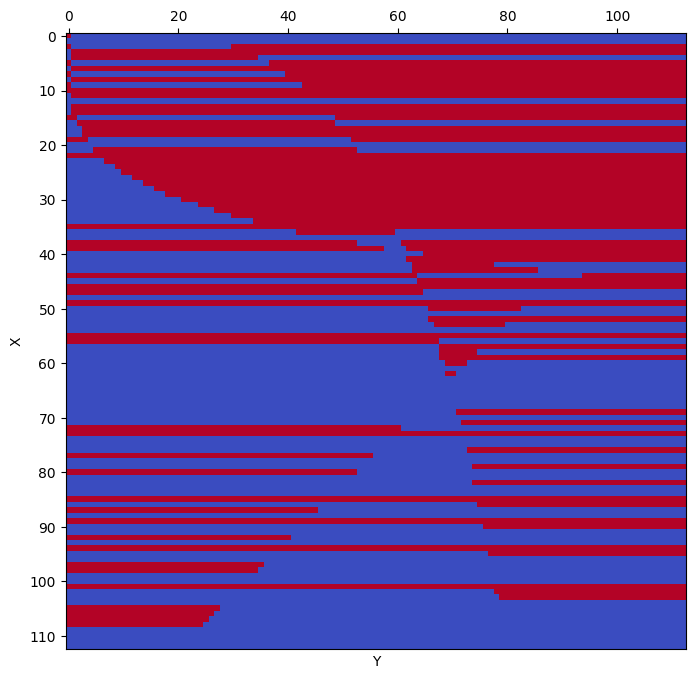

tensor(1., device='cuda:0')
torch.Size([2, 30, 30])
torch.Size([30, 114])


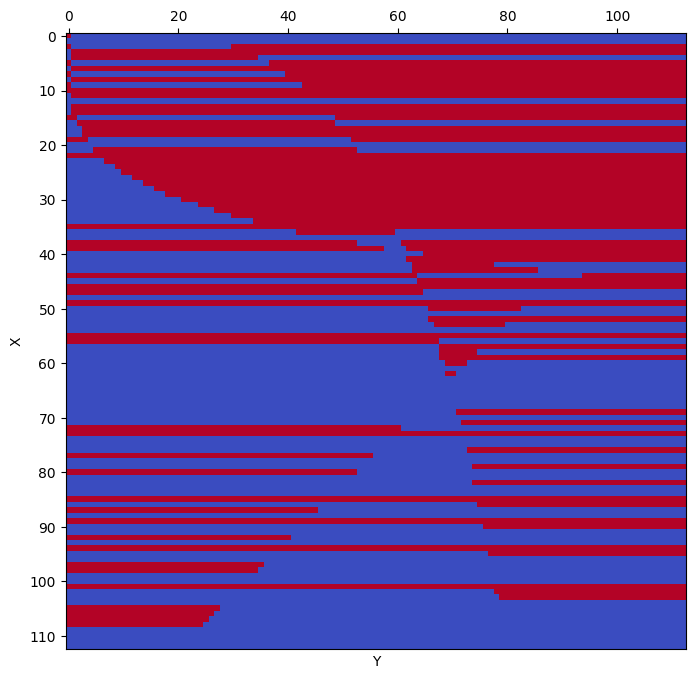

tensor(1., device='cuda:0')


In [28]:
def eval_model(artificial_model):
    # modifies artificial_model
    set_W_E(artificial_model)

    with torch.no_grad():
        indices = torch.stack(torch.meshgrid(torch.arange(113), torch.arange(113)), -1)
        const_val = torch.full((113, 113, 1), 113)
        indices = torch.cat([indices, const_val], axis=2)

        z = artificial_model.forward(indices.reshape(-1, 3).to('cuda'))

        sol = (z[:,2,1] > z[:,2,0])


    plotter((2*sol.reshape(113,113)-1).detach().cpu().numpy())
    print(sum(sum(sol.reshape(113,113) == torch.tensor(labels).to('cuda')))/113/113)
    assert torch.all(sol.reshape(113,113) == torch.tensor(labels).to('cuda'))

set_W_in(artificial_model, use_v2 = False)
set_W_V(artificial_model, use_v2 = False)
eval_model(artificial_model)

set_W_in(artificial_model, use_v2 = True)
set_W_V(artificial_model, use_v2 = True)
eval_model(artificial_model)

# linear probe

In [29]:
    
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
    
def linear_probe():
    activations = defaultdict(dict)
    artificial_model.cache_all(activations, incl_bwd=False)
    output = artificial_model(indices.reshape(-1, 3))
    
    predictions_for_probe = output[:,2,1]>output[:,2,0]
    X_for_probe = activations['blocks.0.hook_resid_mid'][:,2,:]

    # Instantiate the model
    model = LogisticRegression()

    # Reshape Y to be 2D array 
    Y = predictions_for_probe.detach().cpu().numpy().reshape(-1, 1)

    # Fit the model
    model.fit(X_for_probe.detach().cpu().numpy(), Y.ravel())

    # Predict the labels of the training set
    Y_pred = model.predict(X_for_probe.detach().cpu().numpy())

    # Print the accuracy
    print(f'Accuracy: {accuracy_score(Y, Y_pred)}')

indices = torch.stack(torch.meshgrid(torch.arange(113), torch.arange(113)), -1)
const_val = torch.full((113, 113, 1), 113)
indices = torch.cat([indices, const_val], axis=2)

In [30]:
set_W_in(artificial_model, use_v2 = False)
set_W_V(artificial_model, use_v2 = False)
linear_probe()

set_W_in(artificial_model, use_v2 = True)
set_W_V(artificial_model, use_v2 = True)
linear_probe()

torch.Size([2, 30, 30])


C:\Users\rick\anaconda3b\envs\conda_env2\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7552666614456888
torch.Size([2, 30, 30])
Accuracy: 0.8395332445767092


C:\Users\rick\anaconda3b\envs\conda_env2\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# noise

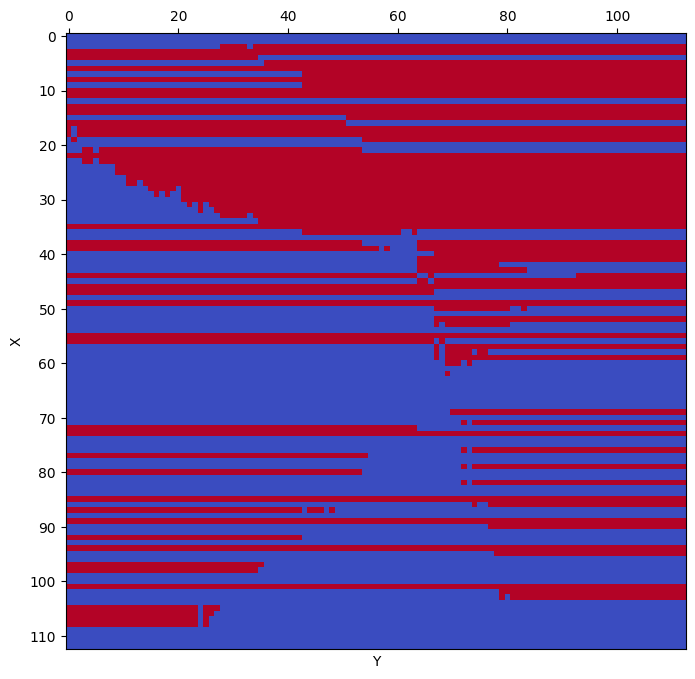

In [31]:
# Cherry-picked parameters sets I like (seed, sd)
# (0, 1.5)
# (0, 2.0)
# (5, 1.5)
np.random.seed(0) 
noise = np.random.normal(0, 2.0, VOMy.shape)
VOMy_noisy = VOMy[:-1]+noise[:-1]
with torch.no_grad():
    artificial_model.embed.W_E[0,:-1] = torch.from_numpy(VOMy_noisy).to('cuda')
    
with torch.no_grad():
    indices = torch.stack(torch.meshgrid(torch.arange(113), torch.arange(113)), -1)
    const_val = torch.full((113, 113, 1), 113)
    indices = torch.cat([indices, const_val], axis=2)
    
    z = artificial_model.forward(indices.reshape(-1, 3))
    # z = z.view(113, 113, -1)
    
    sol_noisy = (z[:,2,1] > z[:,2,0])
    
    
plotter((2*sol_noisy.reshape(113,113)-1).detach().cpu().numpy())

# scratch work

In [32]:
labels[40,64:66]

def f0(x,y):
    return x ** 2 < np.sqrt(y) * 200
print(f0(40,64))
print(f0(40,65))

False
True


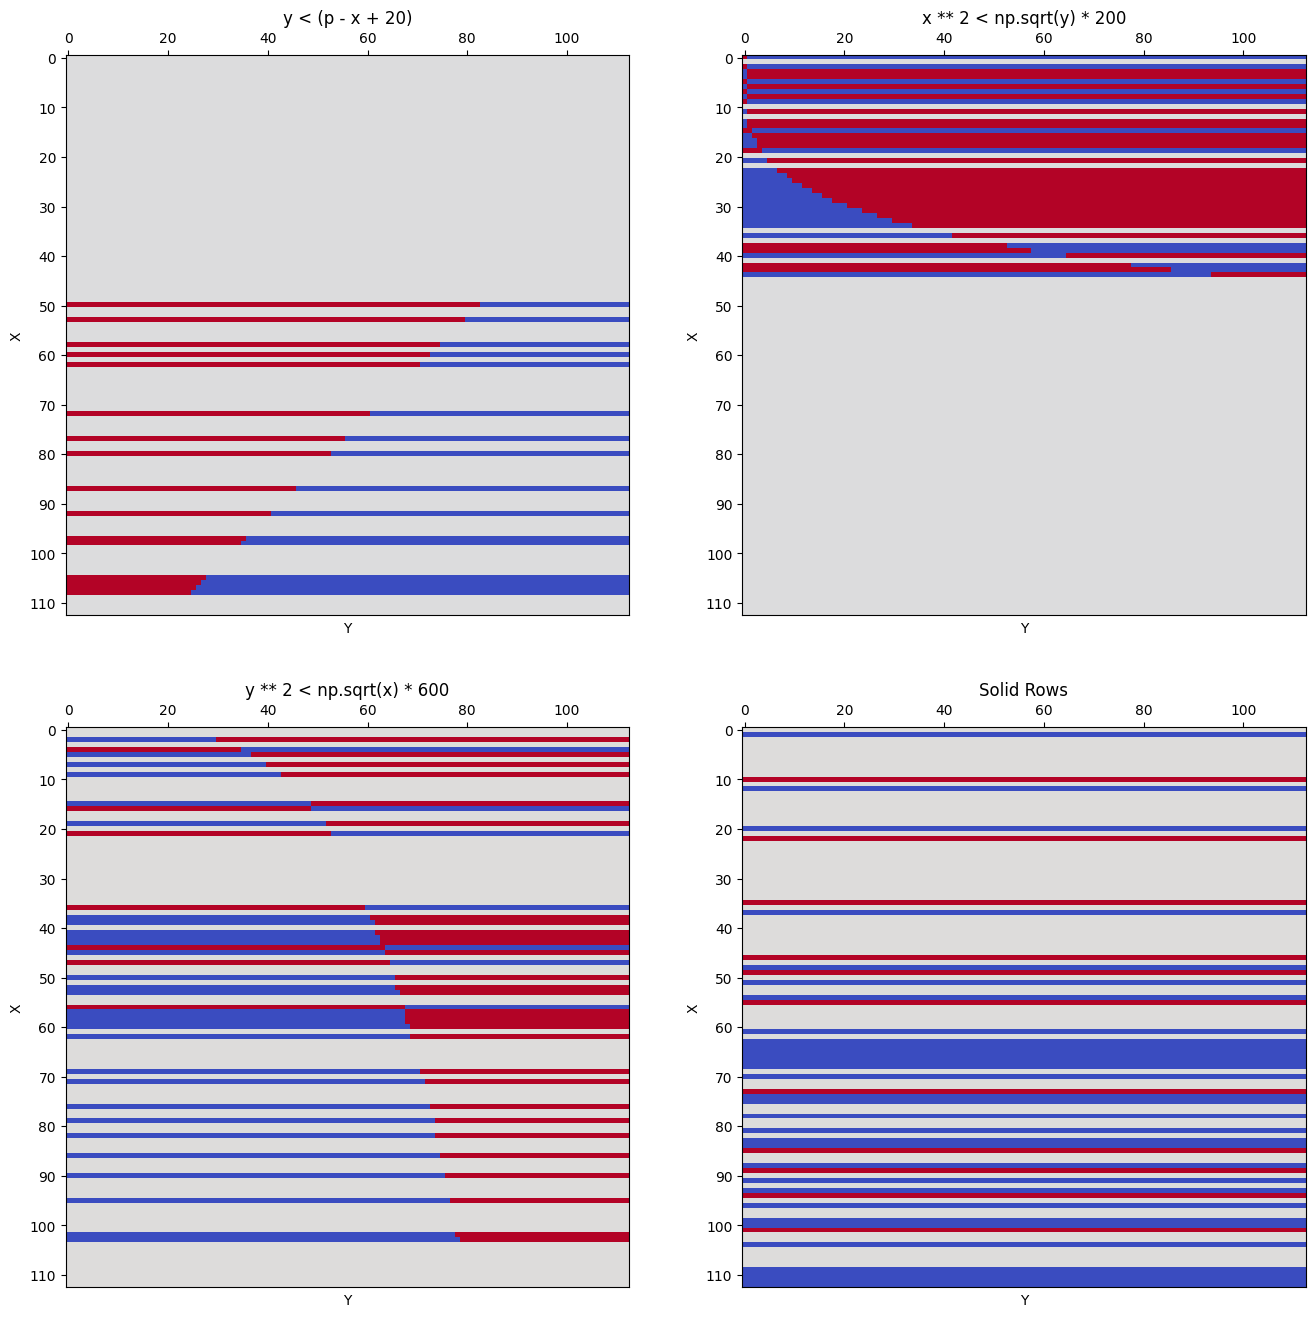

In [33]:
def plotter2(ax, to_plot, title):
    cax = ax.imshow(to_plot, aspect='auto', cmap='coolwarm', vmin=-.1, vmax=.1)
    labels2 = list(range(0, 114,10))
    ax.set_yticks(labels2)
    ax.set_yticklabels(labels2[::1])
    ax.set_xlabel('Y')
    ax.set_ylabel('X')
    ax.set_title(title)
    ax.xaxis.tick_top()

fig, axs = plt.subplots(2, 2, figsize=(16,16))


plotter2(axs[0, 0], MLPs2.ltc-MLPs2.lfc-MLPs2.rfc+MLPs2.rtc+MLPs2.ltw-MLPs2.lfw-MLPs2.rfw+MLPs2.rtw,"y < (p - x + 20)")
plotter2(axs[0, 1], MLPs0.ltw-MLPs0.lfw-MLPs0.rfw+MLPs0.rtw+MLPs0.ltc-MLPs0.lfc-MLPs0.rfc+MLPs0.rtc,"x ** 2 < np.sqrt(y) * 200")
plotter2(axs[1, 0], MLPs1.ltw-MLPs1.lfw-MLPs1.rfw+MLPs1.rtw+MLPs1.ltc-MLPs1.lfc-MLPs1.rfc+MLPs1.rtc,"y ** 2 < np.sqrt(x) * 600")
plotter2(axs[1, 1], MLPx3_t-MLPx3_f,"Solid Rows")

plt.show()